In [ ]:
!unzip IF25-4041-dataset.zip

Archive:  IF25-4041-dataset.zip
  inflating: train.csv               
  inflating: jawaban.csv             
   creating: test/
  inflating: test.csv                
  inflating: __MACOSX/._test.csv     
   creating: train/
  inflating: train/0071.jpg          
  inflating: train/0717.jpg          
  inflating: train/0703.jpg          
  inflating: train/0065.jpg          
  inflating: train/0059.jpg          
  inflating: train/0918.jpg          
  inflating: train/0930.jpg          
  inflating: train/0924.jpg          
  inflating: train/0515.jpg          
  inflating: train/0273.jpg          
  inflating: train/0267.jpg          
  inflating: train/0501.jpg          
  inflating: train/0529.jpg          
  inflating: train/0298.jpg          
  inflating: train/0461.jpg          
  inflating: train/1019.jpg          
  inflating: train/0307.jpg          
  inflating: train/0313.jpg          
  inflating: train/0475.jpg          
  inflating: train/1025.jpg          
  inflating: trai

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

import pandas as pd
from PIL import Image
import os
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# Cek ketersediaan device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Menggunakan device: {device}")

Menggunakan device: cuda


In [ ]:
# Definisikan Custom Dataset Class
class IndonesianFoodDataset(Dataset):
    def __init__(self, annotations_df, img_dir, transform=None):
        self.annotations = annotations_df
        self.img_dir = img_dir
        self.transform = transform
        self.class_to_idx = {label: i for i, label in enumerate(sorted(self.annotations['label'].unique()))}
        self.idx_to_class = {i: label for label, i in self.class_to_idx.items()}

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_filename = self.annotations.iloc[idx, 0]
        img_path = os.path.join(self.img_dir, img_filename)
        image = Image.open(img_path).convert("RGB")
        label_name = self.annotations.iloc[idx, 1]
        label = self.class_to_idx[label_name]
        if self.transform:
            image = self.transform(image)
        return image, label

# Definisikan Transformasi & Augmentasi
IMAGE_SIZE = 224
train_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
val_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Baca dan bagi data
IMAGE_DIR_PATH = 'train'
df = pd.read_csv('train.csv')
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

# Buat instance Dataset
train_dataset = IndonesianFoodDataset(train_df, IMAGE_DIR_PATH, train_transforms)
val_dataset = IndonesianFoodDataset(val_df, IMAGE_DIR_PATH, val_transforms)

# Buat DataLoader
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print("✅ Persiapan data selesai. DataLoader siap digunakan.")

✅ Persiapan data selesai. DataLoader siap digunakan.


In [ ]:
# Blok bangunan untuk Plain Network (tanpa skip connection)
class PlainBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(PlainBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        return out

# Arsitektur PlainNet-34 secara keseluruhan
class PlainNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=5):
        super(PlainNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for s in strides:
            layers.append(block(self.in_channels, out_channels, s))
            self.in_channels = out_channels
        return nn.Sequential(*layers)
    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.maxpool(out)
        out = self.layer1(out); out = self.layer2(out); out = self.layer3(out); out = self.layer4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

def Plain34(num_classes=5):
    return PlainNet(PlainBlock, [3, 4, 6, 3], num_classes=num_classes)

print("✅ Arsitektur Plain-34 berhasil didefinisikan.")

✅ Arsitektur Plain-34 berhasil didefinisikan.


In [ ]:
def train_model(model, criterion, optimizer, num_epochs=10):
    best_val_accuracy = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss, train_corrects = 0.0, 0
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            train_corrects += torch.sum(preds == labels.data)

        # Validation
        model.eval()
        val_loss, val_corrects = 0.0, 0
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validasi]"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)

        # Calculate and print results
        avg_train_loss = train_loss / len(train_loader.dataset)
        avg_train_acc = train_corrects.double() / len(train_loader.dataset)
        avg_val_loss = val_loss / len(val_loader.dataset)
        avg_val_acc = val_corrects.double() / len(val_loader.dataset)

        history['train_loss'].append(avg_train_loss); history['train_acc'].append(avg_train_acc.item())
        history['val_loss'].append(avg_val_loss); history['val_acc'].append(avg_val_acc.item())

        print(f"Epoch {epoch+1} -> Train Loss: {avg_train_loss:.4f}, Acc: {avg_train_acc:.4f} | Val Loss: {avg_val_loss:.4f}, Acc: {avg_val_acc:.4f}")

    return history

print("✅ Fungsi 'train_model' siap digunakan.")

✅ Fungsi 'train_model' siap digunakan.


In [ ]:
# Definisikan Custom Dataset Class
class IndonesianFoodDataset(Dataset):
    def __init__(self, annotations_df, img_dir, transform=None):
        self.annotations = annotations_df
        self.img_dir = img_dir
        self.transform = transform
        self.class_to_idx = {label: i for i, label in enumerate(sorted(self.annotations['label'].unique()))}
        self.idx_to_class = {i: label for label, i in self.class_to_idx.items()}

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_filename = self.annotations.iloc[idx, 0]
        img_path = os.path.join(self.img_dir, img_filename)
        label_name = self.annotations.iloc[idx, 1]
        label = self.class_to_idx[label_name]

        try:
            image = Image.open(img_path).convert("RGB")
        except OSError as e:
            print(f"Skipping corrupted image: {img_path} - {e}")
            # Return None or a placeholder, and handle this in the DataLoader
            # For simplicity, we'll raise the error again to show it happened,
            # but in a real scenario, you might skip or replace the image.
            raise e # Re-raise the error to show the issue during development

        if self.transform:
            image = self.transform(image)
        return image, label

# Definisikan Transformasi & Augmentasi
IMAGE_SIZE = 224
train_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
val_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Baca dan bagi data
IMAGE_DIR_PATH = 'train'
df = pd.read_csv('train.csv')
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

# Buat instance Dataset
train_dataset = IndonesianFoodDataset(train_df, IMAGE_DIR_PATH, train_transforms)
val_dataset = IndonesianFoodDataset(val_df, IMAGE_DIR_PATH, val_transforms)

# Buat DataLoader
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print("✅ Persiapan data selesai. DataLoader siap digunakan.")

✅ Persiapan data selesai. DataLoader siap digunakan.


In [ ]:
print("--- TAHAP 1: MELATIH PLAIN-34 NETWORK (DARI NOL) ---")
model_plain = Plain34(num_classes=5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer_plain = torch.optim.Adam(model_plain.parameters(), lr=0.001)

history_plain = train_model(model_plain, criterion, optimizer_plain, num_epochs=10)

--- TAHAP 1: MELATIH PLAIN-34 NETWORK (DARI NOL) ---


Epoch 1/10 [Training]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 1/10 [Validasi]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 1 -> Train Loss: 1.7432, Acc: 0.2032 | Val Loss: 69.3053, Acc: 0.1622


Epoch 2/10 [Training]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 2/10 [Validasi]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 2 -> Train Loss: 1.6146, Acc: 0.2088 | Val Loss: 1.5862, Acc: 0.3063


Epoch 3/10 [Training]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 3/10 [Validasi]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 3 -> Train Loss: 1.5985, Acc: 0.2506 | Val Loss: 1.6248, Acc: 0.2072


Epoch 4/10 [Training]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 4/10 [Validasi]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 4 -> Train Loss: 1.5809, Acc: 0.2630 | Val Loss: 1.7826, Acc: 0.1351


Epoch 5/10 [Training]:   0%|          | 0/28 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 5/10 [Validasi]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 5 -> Train Loss: 1.5694, Acc: 0.2664 | Val Loss: 2.3084, Acc: 0.3153


Epoch 6/10 [Training]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 6/10 [Validasi]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 6 -> Train Loss: 1.4914, Acc: 0.3036 | Val Loss: 1.7505, Acc: 0.3063


Epoch 7/10 [Training]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 7/10 [Validasi]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 7 -> Train Loss: 1.4568, Acc: 0.3217 | Val Loss: 2.5025, Acc: 0.2523


Epoch 8/10 [Training]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 8/10 [Validasi]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 8 -> Train Loss: 1.3581, Acc: 0.4221 | Val Loss: 1.7326, Acc: 0.3333


Epoch 9/10 [Training]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 9/10 [Validasi]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 9 -> Train Loss: 1.2602, Acc: 0.4481 | Val Loss: 2.1376, Acc: 0.4054


Epoch 10/10 [Training]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 10/10 [Validasi]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 10 -> Train Loss: 1.2588, Acc: 0.4526 | Val Loss: 2.1149, Acc: 0.3784


In [ ]:
print("TAHAP 2: MELATIH RESNET-34")
model_resnet = models.resnet34(weights=None, num_classes=5).to(device)
criterion = nn.CrossEntropyLoss() # Bisa didefinisikan ulang atau tidak
optimizer_resnet = torch.optim.Adam(model_resnet.parameters(), lr=0.001)

history_resnet = train_model(model_resnet, criterion, optimizer_resnet, num_epochs=10)

TAHAP 2: MELATIH RESNET-34


Epoch 1/10 [Training]:   0%|          | 0/28 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/10 [Validasi]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 1 -> Train Loss: 1.5238, Acc: 0.4018 | Val Loss: 5.2139, Acc: 0.2297


Epoch 2/10 [Training]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 2/10 [Validasi]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 2 -> Train Loss: 1.1376, Acc: 0.5519 | Val Loss: 1.3268, Acc: 0.5225


Epoch 3/10 [Training]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 3/10 [Validasi]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 3 -> Train Loss: 0.8995, Acc: 0.6761 | Val Loss: 0.9724, Acc: 0.5991


Epoch 4/10 [Training]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 4/10 [Validasi]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 4 -> Train Loss: 0.8210, Acc: 0.6828 | Val Loss: 1.4069, Acc: 0.5541


Epoch 5/10 [Training]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 5/10 [Validasi]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 5 -> Train Loss: 0.8960, Acc: 0.7144 | Val Loss: 1.9594, Acc: 0.5405


Epoch 6/10 [Training]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 6/10 [Validasi]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 6 -> Train Loss: 0.7970, Acc: 0.7190 | Val Loss: 1.0649, Acc: 0.5946


Epoch 7/10 [Training]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 7/10 [Validasi]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 7 -> Train Loss: 0.7074, Acc: 0.7743 | Val Loss: 1.2436, Acc: 0.5991


Epoch 8/10 [Training]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 8/10 [Validasi]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 8 -> Train Loss: 0.6579, Acc: 0.7799 | Val Loss: 1.1157, Acc: 0.5856


Epoch 9/10 [Training]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 9/10 [Validasi]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 9 -> Train Loss: 0.5688, Acc: 0.8115 | Val Loss: 1.6324, Acc: 0.6171


Epoch 10/10 [Training]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 10/10 [Validasi]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 10 -> Train Loss: 0.5976, Acc: 0.7935 | Val Loss: 0.9318, Acc: 0.6892



--- PERBANDINGAN HASIL AKHIR ---
Akurasi Validasi Terbaik Plain-34: 0.5766
Akurasi Validasi Terbaik ResNet-34: 0.7387


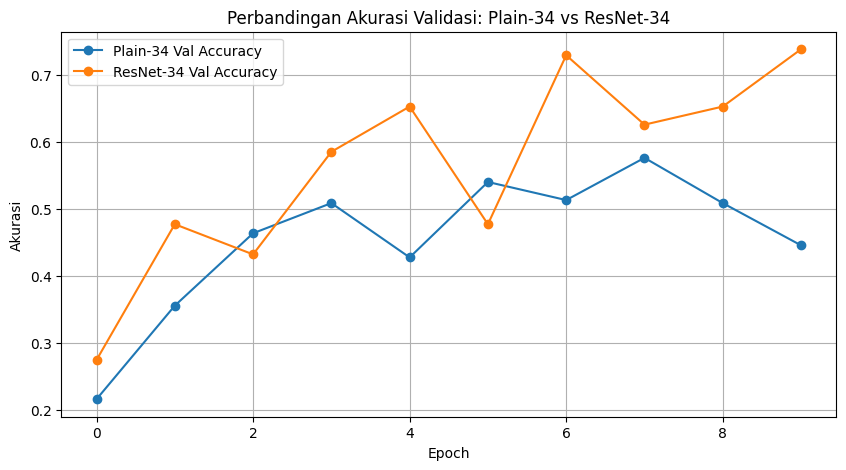

In [ ]:
# Ambil akurasi validasi terbaik dari history
best_plain_acc = max(history_plain['val_acc'])
best_resnet_acc = max(history_resnet['val_acc'])

print("\n--- PERBANDINGAN HASIL AKHIR ---")
print(f"Akurasi Validasi Terbaik Plain-34: {best_plain_acc:.4f}")
print(f"Akurasi Validasi Terbaik ResNet-34: {best_resnet_acc:.4f}")

# Plotting hasil
plt.figure(figsize=(10, 5))
plt.plot(history_plain['val_acc'], label='Plain-34 Val Accuracy', marker='o')
plt.plot(history_resnet['val_acc'], label='ResNet-34 Val Accuracy', marker='o')
plt.title('Perbandingan Akurasi Validasi: Plain-34 vs ResNet-34')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()
plt.grid(True)
plt.show()

**ganti optimizer menjadi SGD dari adam**

In [ ]:
# ==========================================================
# == SEL EKSPERIMEN (F): MENAMBAHKAN DROPOUT PADA RESNET-34 ==
# ==========================================================

print("--- EKSPERIMEN (F): MENAMBAHKAN DROPOUT ---")

# 1. PENTING: Inisialisasi ulang model ke kondisi awal (dari nol)
model_dropout = models.resnet34(weights=None)

# 2. Ganti lapisan klasifikasi terakhir dengan urutan Dropout -> Linear
num_ftrs = model_dropout.fc.in_features
model_dropout.fc = nn.Sequential(
    nn.Dropout(p=0.5), # p=0.5 berarti 50% neuron akan dimatikan secara acak saat training
    nn.Linear(num_ftrs, 5)
)

# 3. Pindahkan model ke device
model_dropout = model_dropout.to(device)

# 4. Buat optimizer baru untuk model ini (gunakan Adam seperti baseline)
# Pastikan 'criterion' sudah didefinisikan di sel sebelumnya
optimizer_dropout = torch.optim.Adam(model_dropout.parameters(), lr=0.001)

# 5. Jalankan fungsi training untuk model yang sudah dimodifikasi ini
print("Memulai training untuk model dengan Dropout...")
history_dropout = train_model(model_dropout, criterion, optimizer_dropout, num_epochs=10)

# 6. Cetak hasil terbaik dari eksperimen ini
best_dropout_acc = max(history_dropout['val_acc'])
print(f"\n--- Hasil Eksperimen (f) ---")
print(f"Akurasi validasi terbaik dengan Dropout adalah: {best_dropout_acc:.4f}")

--- EKSPERIMEN (F): MENAMBAHKAN DROPOUT ---
Memulai training untuk model dengan Dropout...


Epoch 1/10 [Training]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 1/10 [Validasi]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 1 -> Train Loss: 1.6541, Acc: 0.3657 | Val Loss: 5.2948, Acc: 0.3018


Epoch 2/10 [Training]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 2/10 [Validasi]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 2 -> Train Loss: 1.2830, Acc: 0.5192 | Val Loss: 1.7261, Acc: 0.4730


Epoch 3/10 [Training]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 3/10 [Validasi]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 3 -> Train Loss: 1.1664, Acc: 0.5542 | Val Loss: 1.2716, Acc: 0.5811


Epoch 4/10 [Training]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 4/10 [Validasi]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 4 -> Train Loss: 1.0271, Acc: 0.5982 | Val Loss: 1.3226, Acc: 0.5360


Epoch 5/10 [Training]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 5/10 [Validasi]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 5 -> Train Loss: 0.9929, Acc: 0.6264 | Val Loss: 1.6797, Acc: 0.5856


Epoch 6/10 [Training]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 6/10 [Validasi]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 6 -> Train Loss: 0.9477, Acc: 0.6479 | Val Loss: 0.9043, Acc: 0.6306


Epoch 7/10 [Training]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 7/10 [Validasi]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 7 -> Train Loss: 0.8369, Acc: 0.7201 | Val Loss: 0.9904, Acc: 0.6622


Epoch 8/10 [Training]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 8/10 [Validasi]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 8 -> Train Loss: 0.7821, Acc: 0.7111 | Val Loss: 1.0662, Acc: 0.6712


Epoch 9/10 [Training]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 9/10 [Validasi]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 9 -> Train Loss: 0.7647, Acc: 0.7088 | Val Loss: 1.0717, Acc: 0.5991


Epoch 10/10 [Training]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 10/10 [Validasi]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 10 -> Train Loss: 0.7393, Acc: 0.7449 | Val Loss: 0.9893, Acc: 0.6802

--- Hasil Eksperimen (f) ---
Akurasi validasi terbaik dengan Dropout adalah: 0.6802


In [ ]:
# ==========================================================
# == SEL EKSPERIMEN (G): MENGGANTI OPTIMIZER DENGAN SGD     ==
# ==========================================================

print("--- EKSPERIMEN (G): MENGGANTI OPTIMIZER ---")

# 1. PENTING: Inisialisasi ulang model ke kondisi awal (dari nol)
model_sgd = models.resnet34(weights=None)

# 2. Ganti lapisan klasifikasi terakhirnya
num_ftrs = model_sgd.fc.in_features
model_sgd.fc = nn.Linear(num_ftrs, 5)

# 3. Pindahkan model ke device
model_sgd = model_sgd.to(device)

# 4. Buat optimizer baru (SGD dengan Nesterov Momentum)
# Pastikan 'criterion' sudah didefinisikan di sel sebelumnya
optimizer_sgd = torch.optim.SGD(model_sgd.parameters(), lr=0.01, momentum=0.9, nesterov=True)

# 5. Jalankan fungsi training untuk model ini
print("Memulai training untuk model dengan optimizer SGD...")
history_sgd = train_model(model_sgd, criterion, optimizer_sgd, num_epochs=10)

# 6. Cetak hasil terbaik dari eksperimen ini
best_sgd_acc = max(history_sgd['val_acc'])
print(f"\n--- Hasil Eksperimen (g) ---")
print(f"Akurasi validasi terbaik dengan Optimizer SGD adalah: {best_sgd_acc:.4f}")

--- EKSPERIMEN (G): MENGGANTI OPTIMIZER ---
Memulai training untuk model dengan optimizer SGD...


Epoch 1/10 [Training]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 1/10 [Validasi]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 1 -> Train Loss: 1.9031, Acc: 0.3070 | Val Loss: 13.6742, Acc: 0.2027


Epoch 2/10 [Training]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 2/10 [Validasi]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 2 -> Train Loss: 1.2543, Acc: 0.4831 | Val Loss: 1.4715, Acc: 0.5135


Epoch 3/10 [Training]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 3/10 [Validasi]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 3 -> Train Loss: 0.9939, Acc: 0.6321 | Val Loss: 1.6944, Acc: 0.5495


Epoch 4/10 [Training]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 4/10 [Validasi]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 4 -> Train Loss: 0.9513, Acc: 0.6535 | Val Loss: 1.4429, Acc: 0.5090


Epoch 5/10 [Training]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 5/10 [Validasi]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 5 -> Train Loss: 0.7571, Acc: 0.7336 | Val Loss: 0.9323, Acc: 0.6847


Epoch 6/10 [Training]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 6/10 [Validasi]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 6 -> Train Loss: 0.7229, Acc: 0.7528 | Val Loss: 3.0861, Acc: 0.4685


Epoch 7/10 [Training]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 7/10 [Validasi]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 7 -> Train Loss: 0.6677, Acc: 0.7652 | Val Loss: 1.8236, Acc: 0.5495


Epoch 8/10 [Training]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 8/10 [Validasi]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 8 -> Train Loss: 0.5763, Acc: 0.7980 | Val Loss: 0.7741, Acc: 0.7523


Epoch 9/10 [Training]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 9/10 [Validasi]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 9 -> Train Loss: 0.5228, Acc: 0.8262 | Val Loss: 0.8895, Acc: 0.7162


Epoch 10/10 [Training]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 10/10 [Validasi]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 10 -> Train Loss: 0.4333, Acc: 0.8488 | Val Loss: 1.3580, Acc: 0.6982

--- Hasil Eksperimen (g) ---
Akurasi validasi terbaik dengan Optimizer SGD adalah: 0.7523


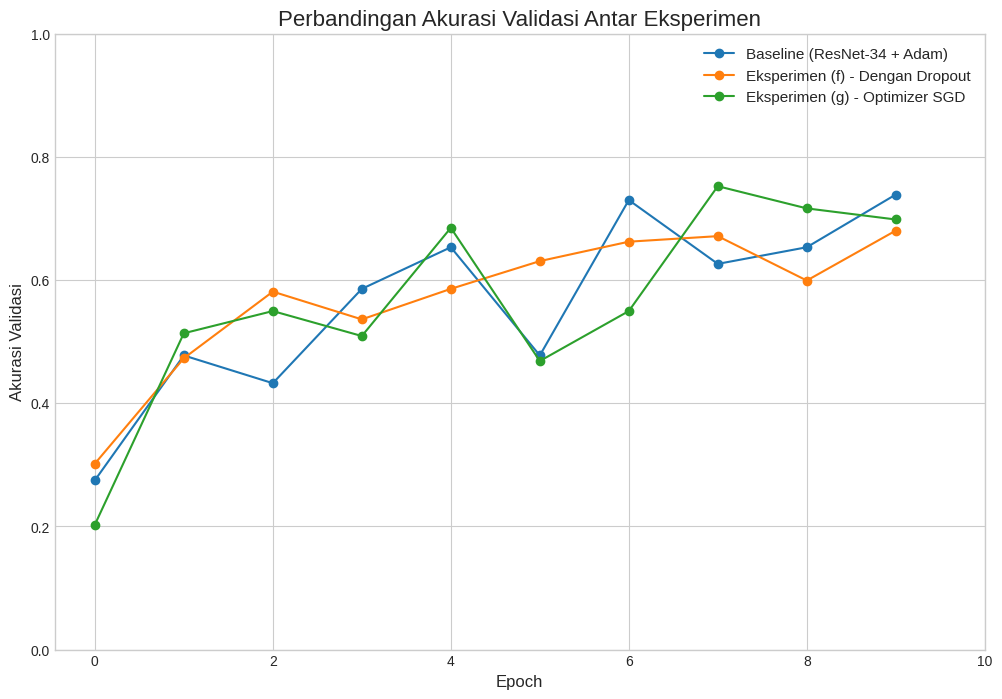

In [ ]:
import matplotlib.pyplot as plt

# Pastikan Anda sudah memiliki variabel history dari setiap eksperimen.
# Sesuaikan nama variabel 'history_baseline' jika Anda menggunakan nama lain
# untuk menyimpan hasil dari Tahap 2.

# Contoh: Jika history Tahap 2 Anda bernama 'history_resnet'
# history_baseline = history_resnet

# Mari kita asumsikan namanya adalah history_resnet dari kode sebelumnya
history_baseline = history_resnet

# Membuat plot
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 8))

# Plot garis untuk setiap eksperimen
plt.plot(history_baseline['val_acc'], label='Baseline (ResNet-34 + Adam)', marker='o')
plt.plot(history_dropout['val_acc'], label='Eksperimen (f) - Dengan Dropout', marker='o')
plt.plot(history_sgd['val_acc'], label='Eksperimen (g) - Optimizer SGD', marker='o')

# Memberi judul dan label
plt.title('Perbandingan Akurasi Validasi Antar Eksperimen', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Akurasi Validasi', fontsize=12)
plt.xticks(range(0, 11, 2)) # Menampilkan label epoch kelipatan 2 agar tidak terlalu padat
plt.legend(fontsize=11)
plt.ylim(0, 1) # Menetapkan batas sumbu y dari 0 hingga 1 untuk akurasi

# Menampilkan plot
plt.show()